# Hybrid Reccomendation System: Content-Based and User-Based Filtering Anime Movie Recommender System
Steps:
1. Collect anime movie data
2. Extract features and Data Preprocessing
4. Find Cosine Similarity for Content-Based 
5. Find Correlation for User-Based
5. Generate hybrid recommendation 

# Library needed to be import

In [271]:
#Pandas tries to determine what dtype to set by analyzing the data in each column.
import pandas as pd
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Variable declaration

In [272]:
# Record start time
start_time = time.time()
#n = number of results/output want print  
n = 10
#target_user = user_id is equal to a specific user 
target_user = 0


# Load dataset into dataframe

In [273]:
#to set the low memory to be false because guessing dtypes for each column is very memory demanding. 
anime_movie_data = pd.read_csv('anime.csv', low_memory = False)
anime_movie_data = pd.DataFrame(anime_movie_data)
anime_movie_data

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [274]:
#user_rating_data = user rating data
user_rating_data = pd.read_csv('rating.csv', low_memory = False)
user_rating_data = user_rating_data[0:6000000]
new_user_rating = pd.read_csv('newRating.csv', low_memory = False)
user_rating_data = pd.DataFrame(user_rating_data)
user_rating_data = pd.concat([user_rating_data, new_user_rating])
user_rating_data

,user_id,anime_id,rating
0,1.0,20.0,-1.0
1,1.0,24.0,-1.0
2,1.0,79.0,-1.0
3,1.0,226.0,-1.0
4,1.0,241.0,-1.0
...,...,...,...
113,75009.0,18617.0,5.0
114,75009.0,25781.0,9.0
115,75009.0,5081.0,7.0
116,75009.0,29755.0,8.0


# Feature Extraction + Data Preprocessing
 Identifying and extracting relevant features from the movie data that can be used to generate recommendations.

# Change Data Type

In [275]:
anime_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [276]:
#change data type
anime_movie_data['episodes'] = anime_movie_data['episodes'].replace('Unknown', -1)
anime_movie_data = anime_movie_data.astype({"name":"string","genre":"string","type":"string","episodes":"int64"})

In [277]:
anime_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  string 
 2   genre     12232 non-null  string 
 3   type      12269 non-null  string 
 4   episodes  12294 non-null  int64  
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(3), string(3)
memory usage: 672.5 KB


In [278]:
user_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   float64
 1   anime_id  float64
 2   rating    float64
dtypes: float64(3)
memory usage: 183.1 MB


In [279]:
#change data type
user_rating_data = user_rating_data.replace([np.inf, -np.inf, np.nan], 0)
user_rating_data = user_rating_data.astype({"user_id":"int64","anime_id":"int64","rating":"int64"})
user_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 183.1 MB


# Put a meningful variable name

In [280]:
#Rename Variable
anime_movie_data = anime_movie_data.rename(columns={"rating": "avg_rating"})
anime_movie_data.head(5)

,anime_id,name,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [281]:
#Rename Variable
user_rating_data = user_rating_data.rename(columns={"rating": "user_rating"})
user_rating_data.head(5)

,user_id,anime_id,user_rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# Removing null value

In [282]:
#Check is missing value in each column of a Data Frame and count the total number of true null or NaN?
anime_movie_data.isna().sum()

anime_id        0
name            0
genre          62
type           25
episodes        0
avg_rating    230
members         0
dtype: int64

In [283]:
#Drop those missing value by removing the row (axis = 0) with missing value; remove column (axis = 1) 
#and inplace = True --> modify the original DataFrame in place.
anime_movie_data.dropna(axis=0, inplace= True)
anime_movie_data.isna().sum()

anime_id      0
name          0
genre         0
type          0
episodes      0
avg_rating    0
members       0
dtype: int64

In [284]:
user_rating_data.isna().sum()

user_id        0
anime_id       0
user_rating    0
dtype: int64

# Removing stop words

In [285]:
tfidf = TfidfVectorizer(stop_words = 'english')


# Clean Text

In [286]:
anime_movie_data

,anime_id,name,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [287]:
# Define a function to clean the text
def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z0-9\s]', ' ', text)
    return text

In [288]:
anime_movie_data['name']=anime_movie_data['name'].apply(clean_text)
anime_movie_data

,anime_id,name,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama 039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover Minami tai Mecha Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi Inma Dens...,Hentai,OVA,1,4.98,175


# Remove duplicate records

In [289]:
# Show duplicate rows based on all columns
duplicate_anime = anime_movie_data[anime_movie_data.duplicated()].shape[0]
print(f'Number of duplicate anime records: {duplicate_anime}')

Number of duplicate anime records: 0


In [290]:
duplicate_rating = user_rating_data[user_rating_data.duplicated()].shape[0]
print(f'Number of duplicate rating records: {duplicate_rating}')

Number of duplicate rating records: 2


In [291]:
#keep = specifies which duplicate values to keep, default = first 
#inplace = specify whether to modify the DataFrame in place or to return a new DataFrame with the duplicates removed. 
user_rating_data.drop_duplicates(keep='first',inplace=True)
duplicate_rating = user_rating_data[user_rating_data.duplicated()].shape[0]
print(f'Number of duplicate rating records: {duplicate_rating}')

Number of duplicate rating records: 0


# Merging 2 dataset based on anime_id

In [292]:
merge_data = pd.merge(user_rating_data, anime_movie_data, on='anime_id', sort = True)
merge_data

,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members
0,13,1,-1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
1,19,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
2,21,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
3,23,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
4,32,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
...,...,...,...,...,...,...,...,...,...
6000009,48766,34367,-1,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports",Special,1,5.97,582
6000010,13954,34475,6,Monster Strike Rain of Memories,"Action, Fantasy, Game",ONA,1,6.58,313
6000011,53492,34475,5,Monster Strike Rain of Memories,"Action, Fantasy, Game",ONA,1,6.58,313
6000012,48766,34476,-1,Platonic Chain Ansatsu Jikkouchuu,"Sci-Fi, Slice of Life",Special,1,1.67,51


In [293]:
#check each anime got how much rating
anime_rating_data = pd.DataFrame(merge_data.groupby('anime_id')['user_rating'].count())
anime_rating_data.head()

,user_rating
anime_id,
1,11729
5,5144
6,8368
7,1843
8,309


# Data Trimming

In [294]:
#to get the number of user rating for each anime 
data_grouping = pd.DataFrame(merge_data.groupby('anime_id')['user_rating'].count()).sort_values(by='user_rating', ascending= False)
data_grouping.describe()

,user_rating
count,11135.000000
mean,538.842748
std,1567.320372
min,1.000000
25%,4.000000
50%,40.000000
75%,299.000000
max,30218.000000


In [295]:
#get the anime that had the number of user rating less than the mean value
trim_data = data_grouping[data_grouping['user_rating'] > data_grouping.mean()[0]]
#trim the data
merge_data = merge_data.loc[merge_data['anime_id'].isin(trim_data.index.values.tolist())]
merge_data

,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members
0,13,1,-1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
1,19,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
2,21,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
3,23,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
4,32,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
...,...,...,...,...,...,...,...,...,...
5999949,55952,34240,8,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
5999950,56035,34240,10,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
5999951,56093,34240,-1,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
5999952,56120,34240,7,Shelter,"Music, Sci-Fi",Music,1,8.38,71136


# Algorithm 1: Content-based filtering

# Construct the TF-IDF matrix

In [296]:
#Compute the TF-IDF matrix based on the name
tfidf_matrix = tfidf.fit_transform(anime_movie_data['name'])
print(type(tfidf_matrix))

<class 'scipy.sparse._csr.csr_matrix'>


In [297]:
tfidf.vocabulary_

{'kimi': 5311,
 'na': 6972,
 'wa': 11116,
 'fullmetal': 2900,
 'alchemist': 386,
 'brotherhood': 1159,
 'gintama': 3239,
 'steins': 9885,
 'gate': 3087,
 '039': 16,
 'haikyuu': 3529,
 'karasuno': 5046,
 'koukou': 5622,
 'vs': 11110,
 'shiratorizawa': 9424,
 'gakuen': 3008,
 'hunter': 4099,
 '2011': 100,
 'ginga': 3229,
 'eiyuu': 2491,
 'densetsu': 2128,
 'movie': 6870,
 'kanketsu': 5002,
 'hen': 3801,
 'yorozuya': 11544,
 'yo': 11471,
 'eien': 2472,
 'nare': 7102,
 'enchousen': 2547,
 'clannad': 1659,
 'story': 9902,
 'koe': 5458,
 'katachi': 5085,
 'code': 1693,
 'geass': 3103,
 'hangyaku': 3653,
 'lelouch': 5949,
 'r2': 8311,
 'second': 9017,
 'season': 9014,
 'sen': 9117,
 'chihiro': 1464,
 'kamikakushi': 4934,
 'shigatsu': 9279,
 'uso': 10978,
 'mushishi': 6944,
 'zoku': 11783,
 'shou': 9509,
 '2nd': 135,
 'ookami': 7674,
 'kodomo': 5456,
 'ame': 431,
 'yuki': 11611,
 'hajime': 3546,
 'ippo': 4385,
 'rurouni': 8696,
 'kenshin': 5196,
 'meiji': 6466,
 'kenkaku': 5182,
 'romantan': 8

# Anime Movie's Name Information

In [298]:
anime_movie_data.name.head()

0                      Kimi no Na wa 
1    Fullmetal Alchemist  Brotherhood
2                            Gintama 
3                         Steins Gate
4                       Gintama  039 
Name: name, dtype: object

In [299]:
name_size = len(anime_movie_data.name)
print(name_size)

12017


# Display movie with same name keywords via 'loc' property
 loc property is used to access a group of rows and columns by label(s)

In [300]:
# Search for the 'Clanned' keyword in name using loc property
anime_by_name = anime_movie_data.copy().loc[anime_movie_data['name'].str.contains('Clannad')]
anime_by_name.head()

,anime_id,name,genre,type,episodes,avg_rating,members
10,4181,Clannad After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
223,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690
370,4059,Clannad Mou Hitotsu no Sekai Tomoyo hen,"Drama, Romance, School, Slice of Life",Special,1,8.14,160423
504,6351,Clannad After Story Mou Hitotsu no Sekai K...,"Drama, Romance, School",Special,1,8.02,138364
2103,1723,Clannad Movie,"Drama, Fantasy, Romance, School",Movie,1,7.35,99506


# Cosine Similarity

In [301]:
# Compute the Cosine Similarity in terms of pairwise similarities
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [302]:
# Create a pandas series where indexes are values and titles are indexes
indices = pd.Series(anime_movie_data.index, index = anime_movie_data['name']).drop_duplicates()

# Check the first 10 indices of anime 
indices[:n]

name
Kimi no Na wa                                                0
Fullmetal Alchemist  Brotherhood                             1
Gintama                                                      2
Steins Gate                                                  3
Gintama  039                                                 4
Haikyuu    Karasuno Koukou VS Shiratorizawa Gakuen Koukou    5
Hunter x Hunter  2011                                        6
Ginga Eiyuu Densetsu                                         7
Gintama Movie  Kanketsu hen   Yorozuya yo Eien Nare          8
Gintama  039   Enchousen                                     9
dtype: int64

# Recommend anime movie function based on cosine similarity

In [303]:
# Define a function to get recommended movies
def get_recommendations_content_based(name, cosine_sim):
    # Get the index of the movie that matches the name
    index = indices[name]

    # Get the pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[index]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 10 most similar movies
    sim_scores = sim_scores[:n]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return anime_movie_data['name'].iloc[movie_indices],  [i[1] for i in sim_scores]

# User input for the specific user id

In [304]:
target_user = int(input('Enter a user id (75000 - 75009) is the new added user:')) 

## Find the user_id is match to the user input 

In [305]:
# Get recommendations for a given movie name by a top rated movie from s specific user id 
target_user_data = merge_data[merge_data['user_id'] == target_user].sort_values(by='user_rating', ascending=False)




# The anime used for do the content-based filtering

In [306]:
#the anime that use to do the content based filtering
target_anime = target_user_data.iloc[0]
pd.DataFrame(target_anime)

,2730457
user_id,75000
anime_id,5114
user_rating,10
name,Fullmetal Alchemist Brotherhood
genre,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
type,TV
episodes,64
avg_rating,9.26
members,793665


# Top 10 recommended anime with similarity scores from content-based 

In [307]:
#get the top rated anime name from the target user 
name = target_user_data['name'].values[0]

content_based_recommendations, sim_scores = get_recommendations_content_based(name, cosine_sim)

# Print the top 10 recommended movies with the similarity score 
content_based_recommendations=pd.DataFrame(content_based_recommendations)
content_based_recommendations['similarity_score'] = sim_scores[:n]
content_based_recommendations = content_based_recommendations[~content_based_recommendations['name'].isin(target_user_data['name'])]
content_based_recommendations 


,name,similarity_score
402,Fullmetal Alchemist Brotherhood Specials,0.950934
200,Fullmetal Alchemist,0.793218
1030,Fullmetal Alchemist Brotherhood 4 Koma Theater,0.775084
1967,Fullmetal Alchemist Reflections,0.605055
1742,Fullmetal Alchemist Premium Collection,0.539734
971,Fullmetal Alchemist The Conqueror of Shamballa,0.508080
1558,Fullmetal Alchemist The Sacred Star of Milos,0.497849
2397,Fullmetal Alchemist The Sacred Star of Milos ...,0.482129
2697,Brotherhood Final Fantasy XV,0.330870


Text(0.5, 1.0, 'Distribution of cosine similarity scores of the anime')

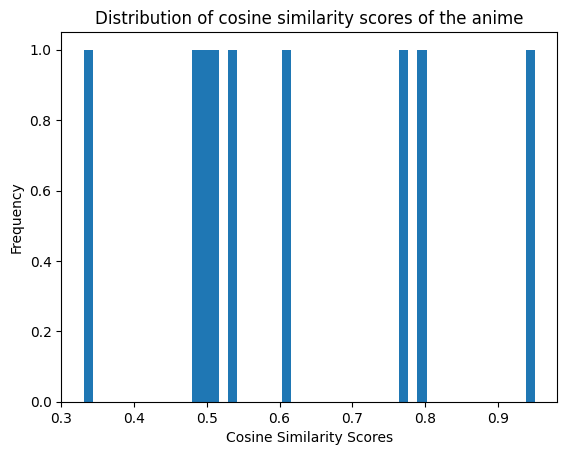

In [308]:
#print the histogram 
plt.hist(content_based_recommendations['similarity_score'], bins=50)
plt.xlabel('Cosine Similarity Scores')
plt.ylabel('Frequency')
plt.title('Distribution of cosine similarity scores of the anime')

## Make  the content-based recommended result to list based on anime_id

In [309]:
#make each of the result to a list 
content_based_recommendations = anime_movie_data.loc[anime_movie_data['name'].isin(content_based_recommendations['name'].tolist())]
content_based_recommendations_list = content_based_recommendations['anime_id'].tolist()
print(f'Content-based recommendation list: {content_based_recommendations_list}')

Content-based recommendation list: [121, 6421, 430, 7902, 9135, 908, 664, 10842, 33080]


# Algorithm 2: User-based collaborative filtering  

# Find the user-item matrix

In [310]:
#matrix which the anime had been rating by the user
user_anime_matrix = merge_data.pivot_table(index = 'user_id', columns = ['anime_id'], values = 'user_rating')
user_anime_matrix.fillna(-1, inplace=True)
user_anime_matrix.head(10)

anime_id,1,5,6,7,15,16,18,19,20,22,...,32668,32681,32729,32828,32935,32998,33028,33558,34103,34240
user_id,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,8.0,-1.0,6.0,-1.0,6.0,-1.0,6.0,5.0,...,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [311]:
merge_data.user_rating.info()

<class 'pandas.core.series.Series'>
Index: 5331531 entries, 0 to 5999953
Series name: user_rating
Non-Null Count    Dtype
--------------    -----
5331531 non-null  int64
dtypes: int64(1)
memory usage: 81.4 MB


In [312]:
anime_user_matrix = user_anime_matrix.transpose()
anime_user_matrix.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,75000,75001,75002,75003,75004,75005,75006,75007,75008,75009
anime_id,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,9.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
15,-1.0,-1.0,-1.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
18,-1.0,-1.0,-1.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
19,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20,-1.0,-1.0,8.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Select a user for target user to compare correlation with other users

In [313]:
anime_user_rating = anime_user_matrix[target_user]
pd.DataFrame(anime_user_rating.sort_values(ascending= False)).rename(columns={target_user: f"user with id {target_user}'s rating"})

,user with id 75000's rating
anime_id,
32935,10.0
5114,10.0
9253,10.0
1,9.0
30276,9.0
...,...
2581,-1.0
2563,-1.0
2520,-1.0


# Find correlation with other users

In [314]:
# Find correlation between user_id = 85 based on the ratings of movies
similar_users = anime_user_matrix.corrwith(anime_user_rating).dropna()
similar_users

user_id
1       -0.003424
2       -0.001711
3        0.059717
5        0.060186
7        0.046377
           ...   
75005   -0.005900
75006    0.322288
75007   -0.004818
75008    0.258660
75009    0.254751
Length: 53203, dtype: float64

# Transform it into Data Frame

In [315]:
# Create a dataframe with similar movies as the index column and correlation as another column
similar_users = pd.DataFrame(similar_users, columns = ['correlation'])
similar_users.head(10)

,correlation
user_id,
1,-0.003424
2,-0.001711
3,0.059717
5,0.060186
7,0.046377
8,-0.005868
9,-0.001711
10,0.190177
11,0.078057


# Show user with highest correlation

In [321]:
#except the most_similar_users[0] = traget_user  
most_similar_users = similar_users.sort_values(by = 'correlation', ascending = False)
most_similar_users = most_similar_users[1:n]
most_similar_users

,correlation
user_id,
4699,0.494923
8581,0.456588
48526,0.449755
29476,0.447886
39488,0.446999
33690,0.442357
18216,0.440467
42633,0.440159
19908,0.430087


## Histogram of distribution of correlation score between users

Text(0.5, 1.0, 'Distribution of correlation scores between user')

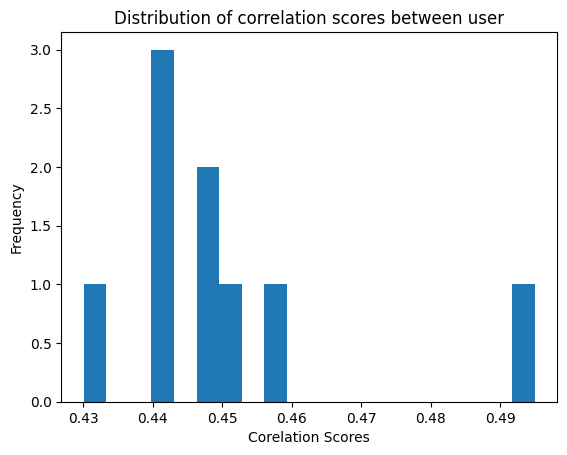

In [322]:
#print the histogram 
plt.hist(most_similar_users['correlation'], bins=20)
plt.xlabel('Corelation Scores')
plt.ylabel('Frequency')
plt.title('Distribution of correlation scores between user')

In [323]:
#print user_id with highest correlation
most_similar_users = most_similar_users.index.values.tolist()
highest_correlation_user = most_similar_users[0]
print(f'User with the highest correlation scores: {highest_correlation_user}')

User with the highest correlation scores: 4699


# 10 best recommend rated anime movie from the user that have highest correlation value

In [ ]:
#sort highest rating to lowest rating
#target_user = merge_data.loc[merge_data['user_id'] == target_user].sort_values(by= 'user_rating', ascending= False)
#recommend anime movie based on similar user
targeted_user = merge_data[merge_data['user_id'] == target_user].sort_values(by ='user_rating', ascending=False)
#trim those anime records had already exist in the user rating
user_based_recommendations = merge_data[merge_data['user_id'] == highest_correlation_user]
user_based_recommendations = user_based_recommendations.sort_values(by = 'user_rating', ascending=False)
user_based_recommendations = user_based_recommendations[~user_based_recommendations['anime_id'].isin(targeted_user['anime_id'].tolist())]

#display result
user_based_recommendations = user_based_recommendations[:n]
user_based_recommendations


,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members
4799397,9929,16498,8,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229


## Make the user-based recommended to a list

In [ ]:
user_based_recommendations_list = user_based_recommendations['anime_id'].tolist()
print(f'User-based recommendation list : {user_based_recommendations_list}')

User-based recommendation list : [16498]


# Merge the 2 algorithm list together

In [ ]:
final_anime_recommend = content_based_recommendations_list.copy()
final_anime_recommend += user_based_recommendations_list.copy()
print(f'Final anime recommendation list : {final_anime_recommend}')

Final anime recommendation list : [32281, 28977, 32935, 28891, 29755, 25303, 30364, 31675, 16498]


# Display the final recommendation

In [ ]:
recommend_anime = anime_movie_data.loc[anime_movie_data['anime_id'].isin(final_anime_recommend)]
recommend_anime.drop_duplicates(subset=['anime_id'], keep=False)
recommend_anime=recommend_anime[:n]
recommend_anime

,anime_id,name,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
5,32935,Haikyuu Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
14,28891,Haikyuu Second Season,"Comedy, Drama, School, Shounen, Sports",TV,25,8.93,179342
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
625,29755,Haikyuu Movie 1 Owari to Hajimari,"Comedy, Drama, School, Shounen, Sports",Movie,1,7.94,13094
626,25303,Haikyuu OVA,"Shounen, Sports",OVA,2,7.93,30063
851,30364,Haikyuu Movie 2 Shousha to Haisha,"Comedy, Drama, School, Shounen, Sports",Movie,1,7.81,10558
4599,31675,Haikyuu Quest Picture Drama,"Comedy, Fantasy, Game, Shounen",OVA,3,6.68,3297


# Time using 

In [ ]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 191.14150857925415 seconds
